In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np

In [3]:
omp = 1
mpi_run = 'mpirun -np 32'

# DFT analysis of GaAs

This notebook contains the analysis of the GaAs (with SO interaction) performed with QuantumESPRESSO. In particular

* GS convergence for the energy cutoff, the number of kpoints and the equilibrium lattice constant
* Plot of the band structure along a path and determination of the value of the scissor nedded to set the gap to 1.42 eV, that correspond
   to the experimental value at 300 K.
* NSCF computations performed on various kpoints samplings, needed for the subsequent RT analysis.
* Analysis of the Dos
* Analysis of the JDos

## GS convergence analysis

In [7]:
run_dir = 'GS_convergence'

We define a basic input object

In [8]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'atomic_species': {'As': ['1.0', 'As_rel.pz-rrkj3.UPF'],
  'Ga': ['1.0', 'Ga_rel.pz-rrkj3.UPF']},
 'cell': {},
 'cell_parameters': {},
 'control': {'calculation': "'scf'",
  'pseudo_dir': "'../pseudos'",
  'verbosity': "'high'"},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'kpoints': {},
 'system': {'celldm(1)': 10.6,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'lspinorb': '.true.',
  'nat': '2',
  'noncolin': '.true.',
  'ntyp': '2',
  'occupations': "'fixed'"}}

We perform a first seek_convergence procedure using the cutoff energy of the wave functions as free parameter.
In this case we set the kpoints sampling on a grid 4,4,4

In [9]:
kvalue = 4
inp.set_kpoints(type='automatic',points=[kvalue,kvalue,kvalue])

We start with the value of 80 as suggested in the specifications of the pseudos (minum allowed is 76 Ry for As)

In [10]:
ecut = [10*i for i in range(8,11)]
ecut

[80, 90, 100]

In [11]:
ecut_conv = D.Dataset(run_dir=run_dir)

In [12]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)
#code.global_options()

Initialize a serial QuantumESPRESSO calculator with scheduler direct


In [13]:
for e in ecut:
    idd = {'ecut' : e, 'k' : kvalue}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_energy_cutoff(e)
    ecut_conv.append_run(id=idd,input=inp,runner=code)

We use a postProcessing function to extract the total energy from the results and run a seek_convergence

In [14]:
ecut_conv.set_postprocessing_function(D.QE_get_energy)

In [15]:
ecut_conv.seek_convergence(rtol=1e-5)

Fetching results for id " {'ecut': 80, 'k': 4} "
Create the sub-directory 'GS_convergence'
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp ecut_80-k_4.in > ecut_80-k_4.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed
Fetching results for id " {'ecut': 90, 'k': 4} "
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp ecut_90-k_4.in > ecut_90-k_4.log
run0_is_running:True  
Job completed
Convergence reached in Dataset "Dataset" for id " {'ecut': 80, 'k': 4} "


({'ecut': 80, 'k': 4}, -8.657253406394746)

In [16]:
ecut_conv = 80

The choice ecut = 80 guarantees a convergence of the gs with a rtol of 1e-5, that corresponds to 0.1 meV.

We perform a second seek_converge on the value of k.

In [17]:
kvalue_conv = D.Dataset(run_dir=run_dir)

In [18]:
inp.set_energy_cutoff(ecut_conv)

In [19]:
kvalues = [4,5,6,7,8]

In [20]:
for k in kvalues:
    idd = {'ecut' : ecut_conv, 'k' : k}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,k])
    kvalue_conv.append_run(id=idd,input=inp,runner=code)

In [21]:
kvalue_conv.set_postprocessing_function(D.QE_get_energy)

In [22]:
kvalue_conv.seek_convergence(rtol=1e-4)

Fetching results for id " {'ecut': 80, 'k': 4} "
Skip the computation for input ecut_80-k_4
Job completed
Fetching results for id " {'ecut': 80, 'k': 5} "
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp ecut_80-k_5.in > ecut_80-k_5.log
run0_is_running:True  
Job completed
Fetching results for id " {'ecut': 80, 'k': 6} "
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp ecut_80-k_6.in > ecut_80-k_6.log
run0_is_running:True  
Job completed
Fetching results for id " {'ecut': 80, 'k': 7} "
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp ecut_80-k_7.in > ecut_80-k_7.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed
Convergence reached in Dataset "Dataset" for id " {'ecut': 80, 'k': 6} "


({'ecut': 80, 'k': 6}, -8.663228888173155)

We choose k = 6 that guarantees convergence at the order of 1meV

In [23]:
k_conv = 6

Lastly, we seek for the equilibrium lattice constants

In [24]:
lat_conv = D.Dataset(run_dir=run_dir)

In [25]:
lat0 = 10.5
scale = 5e-3
deltas = [i for i in range(-3,3)]

In [26]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])

In [27]:
for delta in deltas:
    idd = {'lat_delta' : delta}
    inp.set_prefix(D.name_from_id(idd))
    lat = lat0*(1+delta*scale)
    inp.set_lattice(2,celldm1=lat)
    lat_conv.append_run(id=idd,input=inp,runner=code)

In [28]:
lat_conv.set_postprocessing_function(D.QE_get_energy)

In [29]:
results = lat_conv.run()

Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp lat_delta_-3.in > lat_delta_-3.log
run0_is_running:True  
Job completed
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp lat_delta_-2.in > lat_delta_-2.log
run0_is_running:True  
Job completed
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp lat_delta_-1.in > lat_delta_-1.log
run0_is_running:True  
Job completed
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp lat_delta_0.in > lat_delta_0.log
run0_is_running:True  
run0_is_running:True  
Job completed
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp lat_delta_1.in > lat_delta_1.log
run0_is_running:True  
Job completed
Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp lat_delta_2.in > lat_delta_2.log
run0_is_running:True  
Job completed


We perform a quadratic fit of data

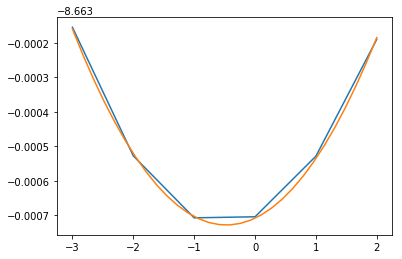

In [30]:
res = [results[i] for i in range(len(deltas))]
coeffs = np.polyfit(deltas,res,2)
values_fit = np.linspace(deltas[0],deltas[-1],30)
res_fit = [coeffs[0]*x**2+coeffs[1]*x+coeffs[2] for x in values_fit]
plt.plot(deltas,res)
plt.plot(values_fit,res_fit)

In [31]:
delta_eq = -coeffs[1]/(2*coeffs[0])
lat_eq = lat0*(1+delta_eq*scale)
lat_eq

10.475218003365393

This is the value of the equilibrium lattice constants. So to summarize

In [4]:
ecut_conv = 80
k_conv = 6
lat_eq = 10.475

We perform a last scf computation for the converged system, that will be used as starting point for the nscf ones

In [33]:
inp.set_lattice(2,celldm1=lat_eq)
prefix = 'gs_converged'
inp.set_prefix(prefix)
#inp

In [34]:
code.run(run_dir=run_dir,inputs=[inp],names=[prefix])

Executing command: cd GS_convergence; mpirun -np 16 pw.x -inp gs_converged.in > gs_converged.log
run0_is_running:True  
Job completed


{'output': ['GS_convergence/gs_converged.save/data-file-schema.xml']}

# Analysis of the band structure

In [8]:
run_dir = 'QE_bands'

We compute the band structure along a path. We use the converged energy_cutoff and lattice parameters.

In [18]:
hsp = U.high_sym_fcc
klist = U.build_kpath(hsp['L'],hsp['G'],hsp['X'],hsp['K'],hsp['G'],numstep=30)
klist

[[0.5, 0.5, 0.5, 30],
 [0.0, 0.0, 0.0, 30],
 [0.0, 0.0, 1.0, 30],
 [0.0, 1.0, 1.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [19]:
pref = 'bands' 

inp = I.PwInput()
inp.set_bands(16,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp.set_prefix(pref)
#inp

In [20]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)

Initialize a serial QuantumESPRESSO calculator with scheduler direct


In [21]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir='GS_convergence/gs_converged.save')

The folder QE_bands/bands.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bands
Job completed


In [22]:
bands = U.BandStructure.from_Pw(result['output'][0],hsp,set_gap=1.42)

Apply a scissor of 0.5456147560258169 eV


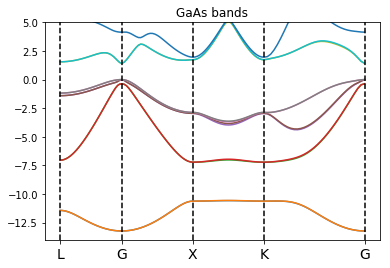

In [23]:
plt.title('GaAs bands')
plt.ylim(-14,5)
bands.plot(plt,selection=[i for i in range(0,11)])

It is useful also to display the band structure evidencing the region around $\Gamma$ that is sampled for the RT analysis

In [24]:
hs_positions = bands.get_high_sym_positions()
hs_positions

(['K', 'G', 'G', 'X', 'L'],
 [2.866025403784435,
  0.8660254037844385,
  4.28023896615753,
  1.8660254037844377,
  0.0])

In [39]:
kspan = 0.05 #in unit of 2pi/alat
k0 = hs_positions[1][1]
k0

0.8660254037844385

(0.0, 1.864)

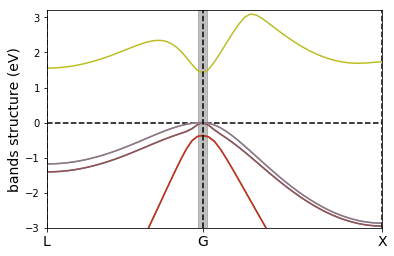

In [56]:
bands.plot(plt,selection=[i for i in range(0,9)])
ax = plt.axes()
ax.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
plt.ylim(-3,3.2)
plt.ylabel('bands structure (eV)',size=14)
plt.hlines(0.,0.,2,linestyles='--')
plt.xlim(0.,1.864)

### Bands structure on $\Gamma-K$ path in the Kpump region

We compute the band structure close to $\Gamma$ on the $\Gamma-K$ path
to show the spin splitting of conduction bands

In [5]:
run_dir = 'QE_bands'

In [7]:
hsp = U.high_sym_fcc
kmax = 0.025
klist = U.build_kpath([0.,-kmax,-kmax],hsp['G'],[0.,kmax,kmax],numstep=30)
klist

[[0.0, -0.025, -0.025, 30], [0.0, 0.0, 0.0, 30], [0.0, 0.025, 0.025, 0]]

In [8]:
pref = 'bands_K-G-K' 

inp = I.PwInput()
inp.set_bands(16,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bands_K-G-K'"},
 'system': {'nbnd': 16,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.475,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ecutwfc': 80},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_rel.pz-rrkj3.UPF'],
  'As': ['1.0', 'As_rel.pz-rrkj3.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, -0.025, -0.025, 30],
   [0.0, 0.0, 0.0, 30],
   [0.0, 0.025, 0.025, 0]]},
 'cell_parameters': {}}

In [9]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)

Initialize a serial QuantumESPRESSO calculator with scheduler direct


In [10]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir='GS_convergence/gs_converged.save')

Copy source_dir GS_convergence/gs_converged.save in the QE_bands/bands_K-G-K.save
Executing command: cd QE_bands; mpirun -np 8 pw.x -inp bands_K-G-K.in > bands_K-G-K.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


In [11]:
bands = U.BandStructure.from_Pw(result['output'][0],hsp,set_gap=1.42)

Apply a scissor of 0.5446695036141547 eV


Text(0,0.5,'bands structure (eV)')

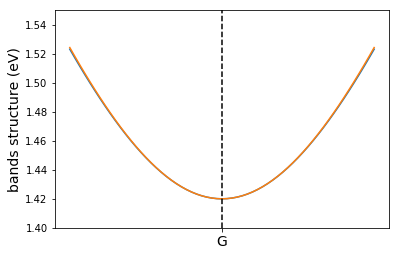

In [13]:
bands.plot(plt,selection=[8,9])
plt.ylim(1.4,1.55)
plt.ylabel('bands structure (eV)',size=14)

In [24]:
hp = bands.get_high_sym_positions()
hp

(['G'], [0.035355339059327376])

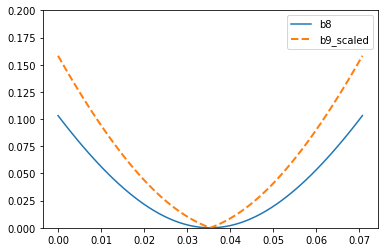

In [30]:
path = bands.get_path()
b = bands.get_bands()
plt.plot(path,b[8]-min(b[8]),label='b8')
plt.plot(path,b[9]*(1+abs(path-hp[1][0]))-min(b[9]),label='b9_scaled',linestyle='--',linewidth=2)
plt.ylim(0,0.2)
plt.legend()

## NSCF computation on various grids

We perform nscf computations on grids of various dimensions and type. These computations will be the starting points for various
RT analysis, to the effects of the kpoints sampling in the real-time reponse of the systems. 

All the computations share the same scf input. The common parameters are

In [4]:
run_dir = 'NSCF'

In [5]:
ecut_conv = 80
k_conv = 6
lat_eq = 10.475
source_dir = 'GS_convergence/gs_converged.save'
num_bands = 16

In [6]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)

Initialize a serial QuantumESPRESSO calculator with scheduler direct


The basic input file is given by

In [7]:
inp = I.PwInput()
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
#inp

### Regular grid

In [8]:
kpoints = 20 #8

In [9]:
idd = {'bnds' : num_bands, 'kpoints' : kpoints}
pref = D.name_from_id(idd)
inp.set_kpoints(type='automatic',points=[kpoints,kpoints,kpoints])
inp.set_prefix(pref)
#inp

In [10]:
result_reg = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_reg

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_16-kpoints_20.save
Executing command: cd NSCF; mpirun -np 32 pw.x -inp bnds_16-kpoints_20.in > bnds_16-kpoints_20.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


{'output': ['NSCF/bnds_16-kpoints_20.save/data-file-schema.xml']}

### Gamma

In [8]:
klist = [[0.0,0.0,0.0,1.0]]

In [9]:
idd = {'bnds' : num_bands, 'sampling' : 'gamma'} 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [10]:
result_gamma = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_gamma

The folder NSCF/bnds_16-sampling_gamma.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bnds_16-sampling_gamma
Job completed


{'output': ['NSCF/bnds_16-sampling_gamma.save/data-file-schema.xml']}

In [12]:
data = P.PwParser(result_gamma['output'][0])

Parse file : NSCF/bnds_16-sampling_gamma.save/data-file-schema.xml


In [13]:
data.get_evals(set_gap=1.42)

Apply a scissor of 0.5456147497318283 eV


array([[-1.32283922e+01, -1.32283922e+01, -3.66966998e-01,
        -3.66966996e-01, -5.68963898e-09, -4.91860508e-09,
        -4.09544487e-09,  0.00000000e+00,  1.42000000e+00,
         1.42000003e+00,  4.13945516e+00,  4.13945520e+00,
         4.34833314e+00,  4.34833315e+00,  4.34833315e+00,
         4.34833318e+00]])

The energy gap due to the light and heavy holes wrt the conduction bands is at 1.42 ev.
Instead the contribution of the split-off bands is at

In [15]:
1.42+3.67e-1

1.787

### Single kpoint close to $\Gamma$

We consider one kpoint close to $\Gamma$ but outside the high symmetry directions of the lattice

In [18]:
#klist = [[0.1,0.03,0.0,1.0]] # a point without simmetries. eps_cv around 2.15 eV anad eps_cc' = 7 meV
#klist = [[-0.0247738, 0.00762269, 0.02365302,1.0]]  # kpoin num 31. Correspond to the max cc' oscillation in Kpump region
klist = [[-0.01655783, 0.00728803, 0.02452443,1.0]] # kpoin num 28. Correspond to the a 'medium' cc' oscillation with 0.602 meV

In [19]:
idd = {'bnds' : num_bands, 'sampling' : '1k-mediumfreq'}   # '1k-nosym'  '1k-maxfreq' 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
print(pref)
inp

bnds_16-sampling_1k-mediumfreq


{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bnds_16-sampling_1k-mediumfreq'"},
 'system': {'nbnd': 16,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.475,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ecutwfc': 80},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_rel.pz-rrkj3.UPF'],
  'As': ['1.0', 'As_rel.pz-rrkj3.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba',
  'values': [[-0.01655783, 0.00728803, 0.02452443, 1.0]]},
 'cell_parameters': {}}

In [20]:
result_1knosym = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_1knosym

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_16-sampling_1k-mediumfreq.save
Executing command: cd NSCF; mpirun -np 8 pw.x -inp bnds_16-sampling_1k-mediumfreq.in > bnds_16-sampling_1k-mediumfreq.log
run0_is_running:True  
Job completed


{'output': ['NSCF/bnds_16-sampling_1k-mediumfreq.save/data-file-schema.xml']}

In [21]:
data = P.PwParser(result_1knosym['output'][0])

Parse file : NSCF/bnds_16-sampling_1k-mediumfreq.save/data-file-schema.xml


In [22]:
eigen = data.get_evals() # we cannot set_gap here because we do not know the gap value at this k point
eigen

array([[-1.32167498e+01, -1.32167496e+01, -3.92969747e-01,
        -3.91980082e-01, -5.99380180e-02, -5.83774160e-02,
        -1.14450904e-04,  0.00000000e+00,  9.62264878e-01,
         9.62867225e-01,  3.61103123e+00,  3.61156342e+00,
         3.81246828e+00,  3.81279328e+00,  3.82476444e+00,
         3.82502579e+00]])

There is energy difference in the spin up and spin down conduction bands

In [23]:
1e3*(eigen[0][9]-eigen[0][8])

0.6023464550386493

The gaps associated to this kpoint are

In [41]:
scissor = 0.5456 # we need to add the scissor at gamma
g1 = eigen[0][8]+scissor-eigen[0][7]
g2 = eigen[0][9]+scissor-eigen[0][7]
g3 = eigen[0][8]+scissor-eigen[0][6]
g4 = eigen[0][9]+scissor-eigen[0][6]
gmean = (g1+g2+g3+g4)/4
gmean

1.5326132052789099

### Random grid close to Gamma

In [8]:
import random as rand
num_kpoints =  200 #100 #50
#k_span = 0.05
k_span = 0.07 # extended_region
weight = [1.]

In [9]:
klist = []
klist.append([0.,0.,0.]+weight) #we include Gamma
for n in range(num_kpoints-1):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + weight
    klist.append(k_rand)

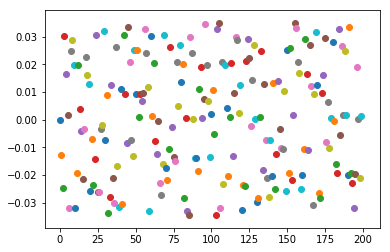

In [10]:
for ind,k in enumerate(klist):
    plt.scatter(ind,k[0])

In [11]:
idd = {'bnds' : num_bands, 'kpoints' : num_kpoints, 'sampling' : 'random_close_Gamma_kspan0.07'}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [12]:
result_random = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir,skip=False)
result_random

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save
Executing command: cd NSCF; mpirun -np 32 pw.x -inp bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.in > bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


{'output': ['NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml']}

In [13]:
data = P.PwParser(result_random['output'][0])

Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml


In [14]:
data.kpoints[28]

[-0.00196744, 0.02461143, 0.01751779]

### Random grid up to 2 eV

In [63]:
import random as rand
num_kpoints =  200 #100
k_span = 0.13
weight = [1.]

In [64]:
klist = []
klist.append([0.,0.,0.]+weight) #we include Gamma
for n in range(num_kpoints-1):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + weight
    klist.append(k_rand)

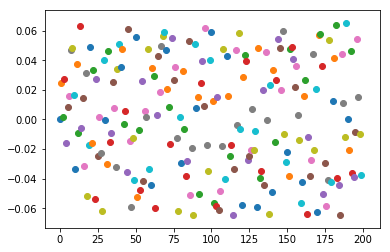

In [65]:
for ind,k in enumerate(klist):
    plt.scatter(ind,k[0])

In [66]:
idd = {'bnds' : num_bands, 'kpoints' : num_kpoints, 'sampling' : 'random'}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [67]:
result_random = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_random

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_16-kpoints_200-sampling_random.save
Executing command: cd NSCF; mpirun -np 16 pw.x -inp bnds_16-kpoints_200-sampling_random.in > bnds_16-kpoints_200-sampling_random.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


{'output': ['NSCF/bnds_16-kpoints_200-sampling_random.save/data-file-schema.xml']}

## Analysis of the Dos

We can compare the Dos associated to the regular grid sampling with the one related to the random samplings.

In [177]:
dos = U.Dos.from_Pw('NSCF/bnds_16-kpoints_8.save/data-file-schema.xml',set_gap=1.42,eta=0.05,label='reg',minVal=-4,maxVal=4)

Apply a scissor of 0.5456147446580722 eV


In [178]:
dos.append_fromPw('NSCF/bnds_16-kpoints_100-sampling_random.save/data-file-schema.xml',label='rand100',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.5456147507640897 eV


In [179]:
dos.append_fromPw('NSCF/bnds_16-kpoints_200-sampling_random.save/data-file-schema.xml',label='rand200',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.5456147507648843 eV


In [180]:
dos.append_fromPw('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml',label='rand50',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.5456147497318283 eV


In [181]:
dos.append_fromPw('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml',label='rand100',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.5456147497318283 eV


We can compare all the dos

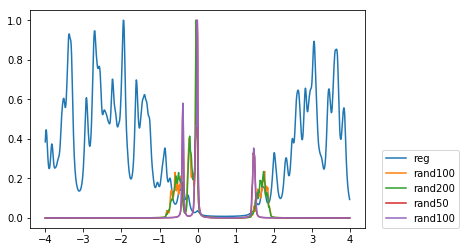

In [182]:
%matplotlib inline
dos.plot(plt,rescale=True)
plt.legend(loc=(1.05,0))

or only the ones associated to random grids

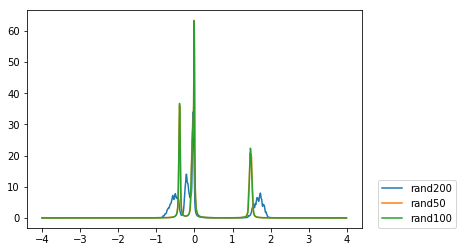

In [183]:
%matplotlib inline
dos.plot(plt,rescale=False,include=[2,3,4])
plt.legend(loc=(1.05,0))

## Analysis of the JDos

We analyze the JDos. We are interested in studying the JDos for both c->v and c->c' transitions. We check the convergence
of the JDos as a test of the kpoints sampling. 

In [15]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')
r_200 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml')
r_200_ext = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml


In [16]:
weights_50 = r_50.weights
weights_100 = r_100.weights
weights_200 = r_200.weights
weights_200_ext = r_200_ext.weights

In [17]:
#transitions_50 = r_50.get_transitions(set_gap=1.42,initial=[2,3,4,5,6,7],final=[8,9])
#transitions_100 = r_100.get_transitions(set_gap=1.42,initial=[2,3,4,5,6,7],final=[8,9])
#transitions_200 = r_200.get_transitions(set_gap=1.42,initial=[2,3,4,5,6,7],final=[8,9])

#without the split-off bands
transitions_50 = r_50.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
transitions_100 = r_100.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
transitions_200 = r_200.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
transitions_200_ext = r_200_ext.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV


In [20]:
dos = U.Dos()
#dos.append_fromPwData(transitions_100,weights_100,minVal=0,maxVal=4,eta=0.004,label='$N_k$=100')
#dos.append_fromPwData(transitions_50,weights_50,minVal=0,maxVal=4,eta=0.004,label='$N_k$=50')
dos.append_fromPwData(transitions_200_ext,weights_200_ext,minVal=0,maxVal=4,eta=0.004,label='200_ext')
dos.append_fromPwData(transitions_200,weights_200,minVal=0,maxVal=4,eta=0.004,label='200')

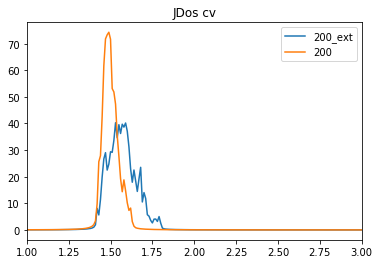

In [21]:
dos.plot(plt)
plt.title('JDos cv')
plt.xlim(1,3)
plt.legend()

In [38]:
dos.append(energies=np.array([1.5]),norm=8,eta=0.04,minVal=1,maxVal=3,label='Field spread',broad_kind=U.gaussian)

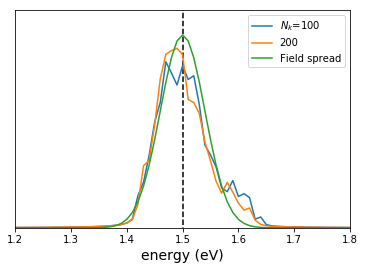

In [40]:
dos.plot(plt,include=[0,2,3])
#plt.title('JDos cv')
plt.vlines(1.5,-2,100,linestyles='--')
plt.yticks([])
plt.xlabel('energy (eV)',size=14)
plt.xlim(1.2,1.8)
plt.ylim(0,90)
plt.legend()

### Analyze the cc' transitions (in meV)

In [22]:
#transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
#transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_200 = 1e3*r_200.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_200_ext = 1e3*r_200_ext.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV


Plot the JDos

In [23]:
dos = U.Dos()
#dos.append_fromPwData(transitions_50,weights_50,minVal=-5,maxVal=5,eta=0.05,label='$N_k$=50')
#dos.append_fromPwData(transitions_100,weights_100,minVal=-5,maxVal=5,eta=0.05,label='$N_k$=100')
dos.append_fromPwData(transitions_200,weights_200,minVal=-5,maxVal=5,eta=0.05,label='$N_k$=200')
dos.append_fromPwData(transitions_200_ext,weights_200_ext,minVal=-5,maxVal=5,eta=0.05,label='$N_k$=200_ext')

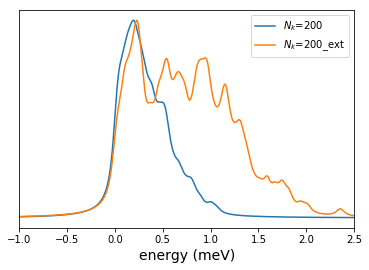

In [26]:
%matplotlib inline
dos.plot(plt,rescale=True)
#plt.title('JDos cc')
plt.xlabel('energy (meV)',size=14)
plt.xlim(-1,2.5)
plt.yticks([])
#plt.vlines(0.3,-0.1,0.4,linestyles='--')
#plt.ylim(0,0.35)
plt.legend()

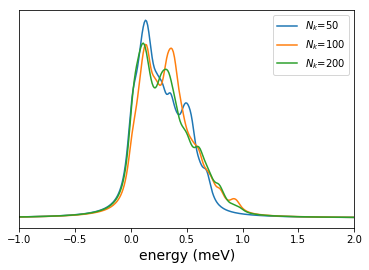

In [47]:
%matplotlib inline
dos.plot(plt)
#plt.title('JDos cc')
plt.xlabel('energy (meV)',size=14)
plt.xlim(-1,2)
plt.yticks([])
#plt.vlines(0.3,-0.1,0.4,linestyles='--')
#plt.ylim(0,0.35)
plt.legend()

We compute the weighted average

In [241]:
ind = 1
eng = dos.dos[ind][0]
dd = dos.dos[ind][1]
wavg = 0.
for e,d in zip(eng,dd):
    wavg += e*d
wavg = wavg/sum(dd)
print(wavg)
U.Planck_ev_ps/(1e-3*wavg)

0.31772410789623445


13.016537282561725

100 kpoints has T = 13.0 ps
50 kpoints has T = 15.4

In [ ]:
###################################################################################

Find the position of the peak of the dos associated to 50 and 100 kpoints (sampling in the k region close to $\Gamma$)

In [217]:
ind = 1
peak = max(dos.dos[ind][1])
max_ind = np.where(dos.dos[ind][1] == peak)
max_energy = dos.dos[ind][0][max_ind][0]
max_energy

0.12999999999989065

The value of the maximum energy corresponds to a time period (in ps) of 

In [218]:
U.Planck_ev_ps/(1e-3*max_energy)

31.81282843079599

100 kpoints has T = 13.34 ps
50 kpoints has T = 15.9